In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images_dir = "training/"
labels = pd.read_csv("training_labels.csv")

# add the directory to the filename
labels['ID'] = labels['ID'].apply(lambda x: os.path.join(images_dir, x))

# Initialize the ImageDataGenerator
# You can change the size of the validation split (0.25 is 25% of data used as validation set)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # You can change the size of the image
    batch_size=32, # You can change the batch_size
    class_mode='categorical',  
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # Should match training size
    batch_size=32, # Should match training
    class_mode='categorical',  
    subset='validation'
)

Found 2591 validated image filenames belonging to 5 classes.
Found 863 validated image filenames belonging to 5 classes.


### ONLY RUN THIS TO SEE THE PICTURES. SKIP IT OTHERWISE

In [3]:
## Plot a few of the images
# 
# # Fetch a batch of images and their labels
# images, labels = next(train_generator)
# 
# # Number of images to show
# num_images = 8
# 
# plt.figure(figsize=(20, 10))
# for i in range(num_images):
#     ax = plt.subplot(2, 4, i + 1)
#     plt.imshow(images[i])
#     # The label for current image
#     label_index = labels[i].argmax()  # Convert one-hot encoding to index
#     label = list(train_generator.class_indices.keys())[label_index]  # Get label name from index
#     plt.title(label)
#     plt.axis('off')
# plt.show()


### Training Code

In [4]:
# base_mod = ResNet50(weights='imagenet')
# 
# # Freeze the base model layers
# for layer in base_mod.layers[-15:]:
#     layer.trainable = True
# 
# # Create the model
# model = Sequential([
#     base_mod,
#     Flatten(),
#     Dense(164, activation='relu', regularization = l2(.01)),
#     Dropout(0.5),
#     Dense(len(labels['target'].unique()), activation='softmax')  # Number of classes
# ])
# 
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 
# # Train the model
# model.fit(
#     train_generator,
#     validation_data= validation_generator, 
#     epochs = 10
# )

### CNN TRY INSTEAD

In [10]:
num_classes = 5

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(224, 224, 3)))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))                  
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))           
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(num_classes, activation='softmax'))

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
cnn_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,325 (16.36 MB)

 Trainable params: 4,288,325 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
n_epochs= 20
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add them to the model's fit function
history = cnn_model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 745ms/step - accuracy: 0.2942 - loss: 1.8110 - val_accuracy: 0.4368 - val_loss: 1.2775 - learning_rate: 0.0010
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - accuracy: 0.5012 - loss: 1.1974 - val_accuracy: 0.5539 - val_loss: 1.1535 - learning_rate: 0.0010
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 363ms/step - accuracy: 0.5504 - loss: 1.1243 - val_accuracy: 0.5435 - val_loss: 1.1154 - learning_rate: 0.0010
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 388ms/step - accuracy: 0.5578 - loss: 1.1327 - val_accuracy: 0.6130 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 381ms/step - accuracy: 0.5913 - loss: 1.0050 - val_accuracy: 0.6362 - val_loss: 0.9645 - learning_rate: 0.0010
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.6448 - loss: 0.9586 - val_accuracy: 0.6385 - val_loss: 0.8998 - learning_rate: 0.0010
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step - accuracy: 0.6628 - loss: 0.

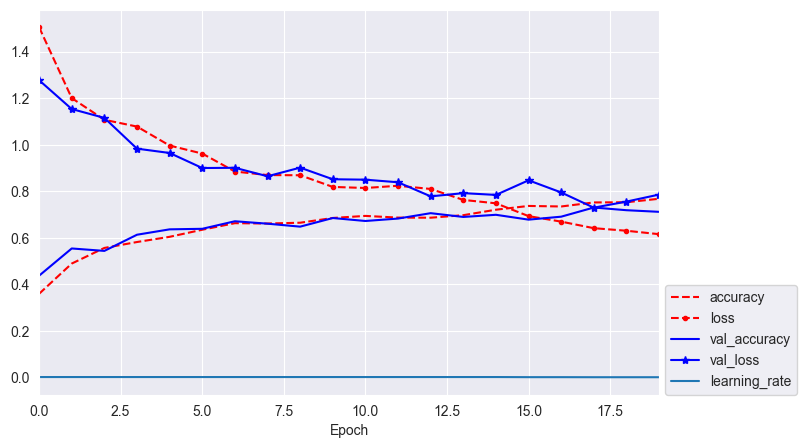

In [13]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0,(n_epochs-1)], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc=(1.01,0))  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

### Test Data!

In [15]:
def load_and_preprocess_images(directory, target_size):
    images = []
    filenames = []
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=target_size)  # Load image with target size
        img_array = img_to_array(img) / 255.0  # Convert to array and scale
        images.append(img_array)
        filenames.append(filename)  # Save the filename (ID)
    
    return np.array(images), filenames

# Directory containing the test images
testing_directory = "testing" 
target_size = (224, 224)  # Adjust based on your model's input size

# Load and preprocess images
test_images, image_ids = load_and_preprocess_images(testing_directory, target_size)

# Make predictions
predictions = cnn_model.predict(test_images)  # Get predictions
predicted_indices = np.argmax(predictions, axis=1)  # Get the class indices

class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Adjust this as necessary

# Convert indices to class labels
predicted_labels = [class_labels[idx] for idx in predicted_indices]

# Prepare the DataFrame
output = pd.DataFrame({
    'ID': image_ids,  # Filenames as IDs
    'Prediction': predicted_labels  # Predicted labels
})

# Save to CSV
output.to_csv("predictions.csv", index=False)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
